In [1]:
import pandas as pd
import numpy as np
from math import pi
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import random
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import mapply
mapply.init(n_workers=7, progressbar=True)
import pickle
with open('scaler.pickle', 'rb') as f:
    scaler: StandardScaler = pickle.load(f)

/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [198]:
def prepare_for_clustering(df, remove_outliers=True, with_indicators=True):
    cat_cols = ['date_month', 'date_day', 'date_year', 'congressional_district', 'state',
            'incident_characteristics1', 'city_or_county', 'party', 'CLEAN', 'OUTLIER']

    orig_num_cols = ['latitude', 'longitude', 'min_age_participants', 'avg_age_participants',
            'max_age_participants', 'n_participants_child', 'n_participants_teen',
            'n_participants_adult', 'n_males', 'n_females', 'n_killed', 'n_injured',
            'n_arrested', 'n_unharmed', 'n_participants', 'timestamp',
            'povertyPercentage', 'candidatevotes', 'totalvotes']

    if remove_outliers:
        df = df[df['OUTLIER'] == 0]

    df.loc[:, cat_cols] = df.loc[:, cat_cols].astype('object')#df[cat_cols] = df[cat_cols].astype('object')
    numerical_df = df.select_dtypes(include=['int64', 'float64'])

    if not with_indicators:
        numerical_df = numerical_df[orig_num_cols]

    scaler = StandardScaler()
    numerical_scaled = scaler.fit_transform(numerical_df)
    numerical_scaled = pd.DataFrame(numerical_scaled, columns=numerical_df.columns)

    return numerical_df, numerical_scaled, scaler


def features_reduction_corr(df, correlation_threshold=0.7):
    # Compute the correlation matrix
    correlation_matrix = df.corr()

    # Identify highly correlated features
    highly_correlated_features = set()

    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
                colname = correlation_matrix.columns[i]
                highly_correlated_features.add(colname)

    # Remove highly correlated features
    df_filtered = df.drop(columns=highly_correlated_features)
    return df_filtered


def features_reduction_var(df, variance_threshold=2):
    # Compute the variance of each feature
    feature_variances = df.var()

    # Identify features below the variance threshold
    low_variance_features = feature_variances[feature_variances < variance_threshold].index

    # Prune (remove) features below the threshold
    df_pruned = df.drop(columns=low_variance_features)

    return df_pruned


def k_means(df, k_min, k_max, n_samples=1, sample_size=-1, initial_centroids=None, max_iter=300):
    if sample_size == -1:
        sample_size = df.shape[0]

    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    numeric_df = df[numeric_cols]
    
    modelss = [[], []]
    sampless = [[], []]

    for i in range(0, k_max):
        modelss.append([])
        sampless.append([])
        
    for i in range(0, n_samples):
        sample = numeric_df.sample(n=sample_size).copy()
        for k in tqdm(range(k_min, k_max+1)):
            if initial_centroids is None:
                model = KMeans(n_clusters=k, n_init=10, max_iter=max_iter)
            else:
                model = KMeans(n_clusters=k, n_init=10, max_iter=max_iter, init=initial_centroids)
            labels = model.fit_predict(sample)

            modelss[k].append(model)
            sampless[k].append(sample)

    return modelss, sampless


def scores(modelss, sampless, k_min, k_max, sample_size=-1, n_samples=1):
    SSEss = []
    separationss = []
    silhouettess = []

    for i in range(0, k_min):
        SSEss.append([])
        separationss.append([])
        silhouettess.append([])
    
    modelss = modelss[k_min:k_max+1]
    sampless = sampless[k_min:k_max+1]

    k = k_min
    for models, samples in zip(modelss, sampless):
        print(f'k = {k}')
        SSEs = []
        separations = []
        silhouettes = []

        for model, sample in zip(models, samples):
            SSEs.append(model.inertia_)
            separations.append(metrics.davies_bouldin_score(sample, model.labels_))
            for j in tqdm(range(0, n_samples)):
                if sample_size == -1:
                    sample_size = len(sample)
                
                sampled_indeces = random.sample(range(len(sample)), sample_size)
                sampled_points = [sample.iloc[i] for i in sampled_indeces]
                sampled_labels = [model.labels_[i] for i in sampled_indeces]

                silhouettes.append(silhouette_score(sampled_points, sampled_labels))
        
        SSEss.append(SSEs)
        separationss.append(separations)
        silhouettess.append(silhouettes)

        k += 1
    
    scoress_dict = {
        'SSE': SSEss,
        'Separation': separationss,
        'Silhouette': silhouettess
    }

    return scoress_dict


def perform_PCA(df, centroids=None, n_components=2):
    pca = PCA(n_components=n_components)

    points_pca = pca.fit_transform(df)
    if centroids is not None:
        centroids_pca = pca.transform(centroids)
        return points_pca, centroids_pca
    return points_pca


def find_features(df, columns, col_scores, threshold=0.1):
    prev_max_score = max(col_scores)
    actual_cols = [columns.pop(0)]
    
    for col in columns:
        actual_cols.append(col)
        scores, _, _ = k_means(df=df[actual_cols], n_samples=1, sample_size=10000, k_min=2, k_max=10)
        max_score = max(scores)
        if np.abs(prev_max_score - max_score) > 0.1:#prev_max_score > max_score:
            actual_cols.pop()
            print(col + ' discarded')
            print('actual score: ' + str(max_score))
        else:
            if prev_max_score < max_score:
                prev_max_score = max_score
            print(col + ' added')
            print('actual score: ' + str(max_score))
    return actual_cols, prev_max_score


def order_features(df):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    numeric_df = df[numeric_cols]
    columns = numeric_df.columns.tolist()
    #random.shuffle(columns)

    max_scores = []
    for col in columns:
        scores, _, _ = k_means(df=df[[col]], n_samples=1, sample_size=10000, k_min=2, k_max=9)
        max_scores.append(max(scores))

    combined = list(zip(columns, max_scores))
    sorted_combined = sorted(combined, key=lambda x: x[1], reverse=True)
    sorted_cols = [item for item, score in sorted_combined]
    sorted_scores = [score for item, score in sorted_combined]

    return sorted_cols, sorted_scores


def sample_columns(df, num_columns_to_sample=1):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    numeric_df = df[numeric_cols]
    df_reduced = numeric_df.sample(n=num_columns_to_sample, axis=1).copy()
    return df_reduced


def show_scores(scoress_dict, k_min, k_max):
    col = 0
    k_values = np.arange(k_min, k_max+1)
    fig, axes = plt.subplots(nrows=1, ncols=len(scoress_dict), figsize=(15, 3))

    for key in scoress_dict:
        scoress = scoress_dict[key]
        mean_scores = []
        
        for k in k_values:
            mean_scores.append(np.mean(np.array(scoress[k])))
        
        axes[col].plot(k_values, mean_scores)
        axes[col].set_title(key)
        axes[col].set_xlabel('Number of clusters')
        axes[col].set_ylabel(key)
        col += 1

    plt.tight_layout()
    plt.show()

    return mean_scores

In [3]:
df = pd.read_csv('./dataset/data/final_clean2.csv')

df_with_out, df_with_out_s, scaler_with_out = prepare_for_clustering(df, remove_outliers=False, with_indicators=True)
df_no_out, df_no_out_s, scaler_no_out = prepare_for_clustering(df, remove_outliers=True, with_indicators=True)
df_with_out_orig, df_with_out_orig_s, scaler_with_out_orig = prepare_for_clustering(df, remove_outliers=False, with_indicators=False)
df_no_out_orig, df_no_out_orig_s, scaler_no_out_orig = prepare_for_clustering(df, remove_outliers=True, with_indicators=False)

print(f'Dataset dimentions: {df.shape}')
print(f'Dataset dimentions with ouliers, with only numerical cols, with indicators: {df_with_out.shape}')
print(f'Dataset dimentions without ouliers, with only numerical cols, with indicators: {df_no_out.shape}')
print(f'Dataset dimentions with ouliers, with only numerical cols, without indicators: {df_with_out_orig.shape}')
print(f'Dataset dimentions without ouliers, with only numerical cols, without indicators: {df_no_out_orig.shape}')

Dataset dimentions: (235219, 61)
Dataset dimentions with ouliers, with only numerical cols, with indicators: (235219, 51)
Dataset dimentions without ouliers, with only numerical cols, with indicators: (190977, 51)
Dataset dimentions with ouliers, with only numerical cols, without indicators: (235219, 19)
Dataset dimentions without ouliers, with only numerical cols, without indicators: (190977, 19)


In [327]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235219 entries, 0 to 235218
Data columns (total 61 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   date_year                             235219 non-null  object 
 1   date_month                            235219 non-null  object 
 2   state                                 235219 non-null  object 
 3   congressional_district                235219 non-null  object 
 4   incident_characteristics1             235219 non-null  object 
 5   date_day                              235219 non-null  object 
 6   city_or_county                        235219 non-null  object 
 7   latitude                              235219 non-null  float64
 8   longitude                             235219 non-null  float64
 9   min_age_participants                  235219 non-null  float64
 10  avg_age_participants                  235219 non-null  float64
 11  

### Original dataset (i.e. dataset without indicators)

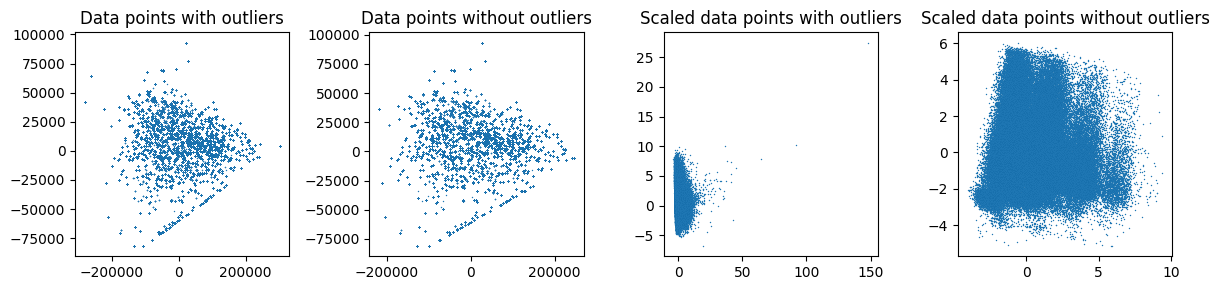

In [4]:
pca_with_out = perform_PCA(df=df_with_out_orig, n_components=2)
pca_no_out = perform_PCA(df=df_no_out_orig, n_components=2)

pca_with_out_s = perform_PCA(df=df_with_out_orig_s, n_components=2)
pca_no_out_s = perform_PCA(df=df_no_out_orig_s, n_components=2)

plt.figure(figsize=(12, 3))

plt.subplot(1, 4, 1)
plt.scatter(pca_with_out[:, 0], pca_with_out[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Data points with outliers')

plt.subplot(1, 4, 2)
plt.scatter(pca_no_out[:, 0], pca_no_out[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Data points without outliers')

plt.subplot(1, 4, 3)
plt.scatter(pca_with_out_s[:, 0], pca_with_out_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Scaled data points with outliers')

plt.subplot(1, 4, 4)
plt.scatter(pca_no_out_s[:, 0], pca_no_out_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Scaled data points without outliers')

plt.tight_layout()
plt.show()

### Augmented dataset

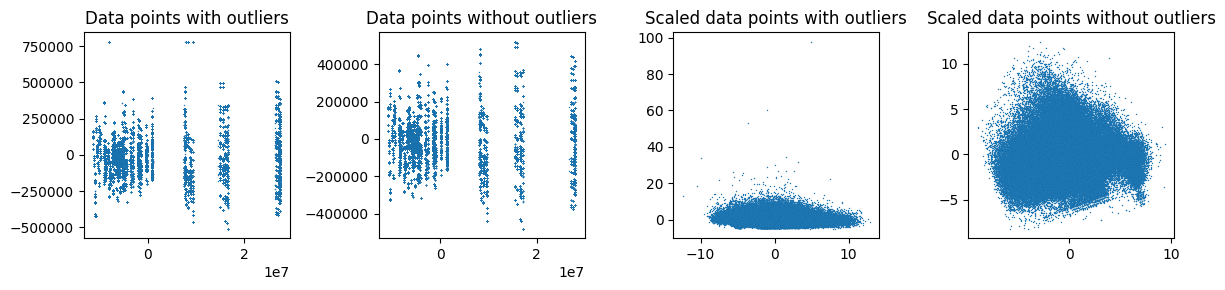

In [5]:
pca_with_out = perform_PCA(df=df_with_out, n_components=2)
pca_no_out = perform_PCA(df=df_no_out, n_components=2)

pca_with_out_s = perform_PCA(df=df_with_out_s, n_components=2)
pca_no_out_s = perform_PCA(df=df_no_out_s, n_components=2)

plt.figure(figsize=(12, 3))

plt.subplot(1, 4, 1)
plt.scatter(pca_with_out[:, 0], pca_with_out[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Data points with outliers')

plt.subplot(1, 4, 2)
plt.scatter(pca_no_out[:, 0], pca_no_out[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Data points without outliers')

plt.subplot(1, 4, 3)
plt.scatter(pca_with_out_s[:, 0], pca_with_out_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Scaled data points with outliers')

plt.subplot(1, 4, 4)
plt.scatter(pca_no_out_s[:, 0], pca_no_out_s[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Scaled data points without outliers')

plt.tight_layout()
plt.show()

# K-means

### K-means experiments on the original dataset (without outliers)

#### K-means on the full original dataset

In [6]:
k_min = 2
k_max = 10

modelss, sampless = k_means(df=df_no_out_orig_s, k_min=k_min, k_max=k_max, max_iter=300)

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:36<00:00,  4.02s/it]


k = 2


100%|██████████| 3/3 [00:15<00:00,  5.30s/it]


k = 3


100%|██████████| 3/3 [00:15<00:00,  5.14s/it]


k = 4


100%|██████████| 3/3 [00:15<00:00,  5.08s/it]


k = 5


100%|██████████| 3/3 [00:15<00:00,  5.08s/it]


k = 6


100%|██████████| 3/3 [00:15<00:00,  5.08s/it]


k = 7


100%|██████████| 3/3 [00:14<00:00,  4.90s/it]


k = 8


100%|██████████| 3/3 [00:14<00:00,  4.98s/it]


k = 9


100%|██████████| 3/3 [00:14<00:00,  4.80s/it]


k = 10


100%|██████████| 3/3 [00:14<00:00,  4.70s/it]


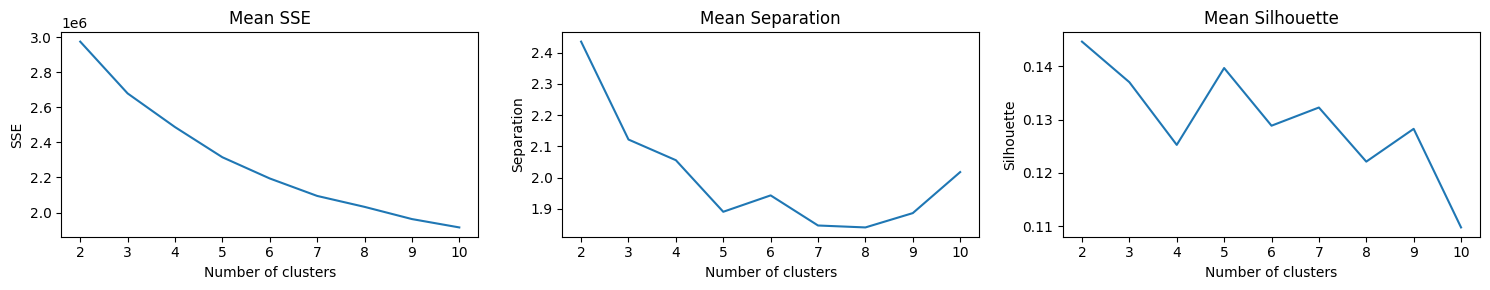

In [48]:
scoress_dict = scores(modelss=modelss, sampless=sampless, k_min=k_min, k_max=k_max, sample_size=5000, n_samples=3)
mean_scores = show_scores(scoress_dict=scoress_dict, k_min=k_min, k_max=k_max)

In [80]:
# Too much time to compute the silouette score on the entire dataset -> sampling

best_k = np.argmax(mean_scores)+k_min

scoress_dict = scores(modelss=modelss, sampless=sampless, k_min=best_k, k_max=best_k, sample_size=10000, n_samples=5)

print(f'\nBest mean silhouette score for k = {best_k}:')

for key in scoress_dict:
    print(f'{key} = {np.mean(scoress_dict[key][best_k])}')

k = 2


100%|██████████| 5/5 [00:42<00:00,  8.49s/it]

Best mean score for k = 2:
SSE = 2974152.7060694294
Separation = 2.4354931071492247
Silhouette = 0.14582580217325097


In [129]:
modelss, sampless = k_means(df_no_out_orig_s, k_min=best_k, k_max=best_k, max_iter=1000000)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


In [91]:
scoress_dict = scores(modelss=modelss, sampless=sampless, k_min=best_k, k_max=best_k, sample_size=10000, n_samples=5)

print(f'\nk = {best_k}:')

for key in scoress_dict:
    print(f'{key} = {np.mean(scoress_dict[key][best_k])}')

k = 2


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:40<00:00,  8.14s/it]


k = 2:
SSE = 2974152.4876594036
Separation = 2.4354415827923126
Silhouette = 0.14672382784231047


/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


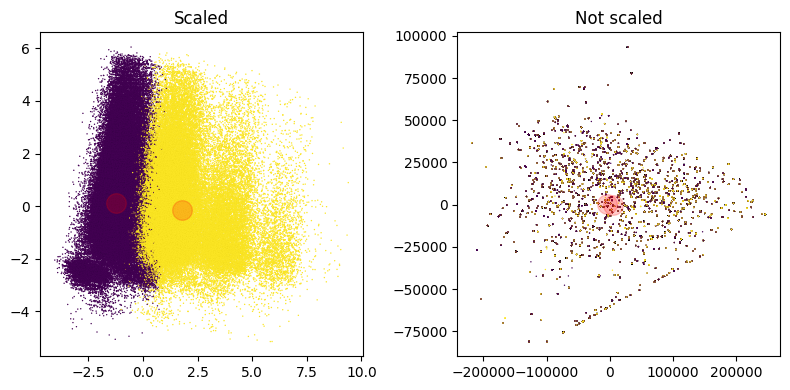

Cluster 0: 112724 points
Cluster 1: 78253 points


In [135]:
best_model = modelss[best_k][0]
best_model_samples = sampless[best_k][0]

points_pca_s, centroids_pca_s = perform_PCA(df=best_model_samples, centroids=best_model.cluster_centers_, n_components=2)

orig_points = scaler_no_out_orig.inverse_transform(best_model_samples)
orig_centroids = scaler_no_out_orig.inverse_transform(best_model.cluster_centers_)

points_pca, centroids_pca = perform_PCA(df=orig_points, centroids=orig_centroids, n_components=2)

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.scatter(points_pca_s[:, 0], points_pca_s[:, 1], c=best_model.labels_, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca_s[:, 0], centroids_pca_s[:, 1], c='red', s=200, alpha=0.2)
plt.title('Scaled')

plt.subplot(1, 2, 2)
plt.scatter(points_pca[:, 0], points_pca[:, 1], c=best_model.labels_, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', s=200, alpha=0.2)
plt.title('Not scaled')

plt.tight_layout()
plt.show()

cluster_labels, cluster_counts = np.unique(best_model.labels_, return_counts=True)
for l, c in zip(cluster_labels, cluster_counts):
    print(f'Cluster {l}: {c} points')

##### Feature reduction using variance:

In [234]:
reduced_no_out_orig_var = features_reduction_var(df_no_out_orig_s, variance_threshold=1)
print('Survived columns (without outliers):----------------------------------------------')
print(f'n_cols = {len(reduced_no_out_orig_var.columns)}')
print(reduced_no_out_orig_var.columns)

Survived columns (without outliers):----------------------------------------------
n_cols = 18
Index(['latitude', 'longitude', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_participants_teen', 'n_participants_adult',
       'n_males', 'n_females', 'n_killed', 'n_injured', 'n_arrested',
       'n_unharmed', 'n_participants', 'timestamp', 'povertyPercentage',
       'candidatevotes', 'totalvotes'],
      dtype='object')


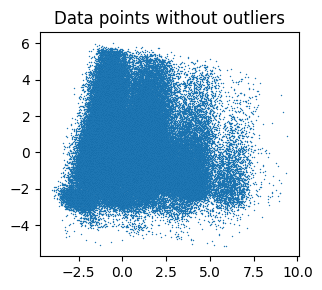

In [235]:
pca_no_out = perform_PCA(df=reduced_no_out_orig_var, n_components=2)


plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.scatter(pca_no_out[:, 0], pca_no_out[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Data points without outliers')

plt.tight_layout()
plt.show()

##### Feature reduction using correlation:

In [263]:
reduced_no_out_orig = features_reduction_corr(reduced_no_out_orig_var, correlation_threshold=0.25)
print('Survived columns (without outliers):----------------------------------------------')
print(f'n_cols = {len(reduced_no_out_orig.columns)}')
print(reduced_no_out_orig.columns)

Survived columns (without outliers):----------------------------------------------
n_cols = 6
Index(['latitude', 'longitude', 'min_age_participants', 'n_participants_teen',
       'n_killed', 'timestamp'],
      dtype='object')


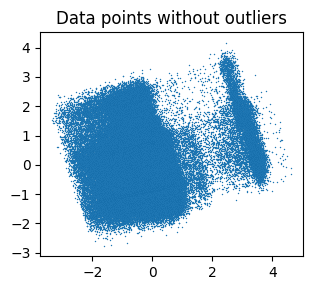

In [264]:
pca_no_out = perform_PCA(df=reduced_no_out_orig, n_components=2)


plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.scatter(pca_no_out[:, 0], pca_no_out[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Data points without outliers')

plt.tight_layout()
plt.show()

#### K-means on the reduced original dataset

In [265]:
k_min = 2
k_max = 10

modelss, sampless = k_means(df=reduced_no_out_orig, k_min=k_min, k_max=k_max, max_iter=300)

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:26<00:00,  2.92s/it]


k = 2


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:06<00:00,  2.29s/it]


k = 3


100%|██████████| 3/3 [00:07<00:00,  2.46s/it]


k = 4


100%|██████████| 3/3 [00:07<00:00,  2.53s/it]


k = 5


100%|██████████| 3/3 [00:07<00:00,  2.37s/it]


k = 6


100%|██████████| 3/3 [00:08<00:00,  2.91s/it]


k = 7


100%|██████████| 3/3 [00:08<00:00,  2.73s/it]


k = 8


100%|██████████| 3/3 [00:07<00:00,  2.40s/it]


k = 9


100%|██████████| 3/3 [00:06<00:00,  2.18s/it]


k = 10


100%|██████████| 3/3 [00:06<00:00,  2.33s/it]


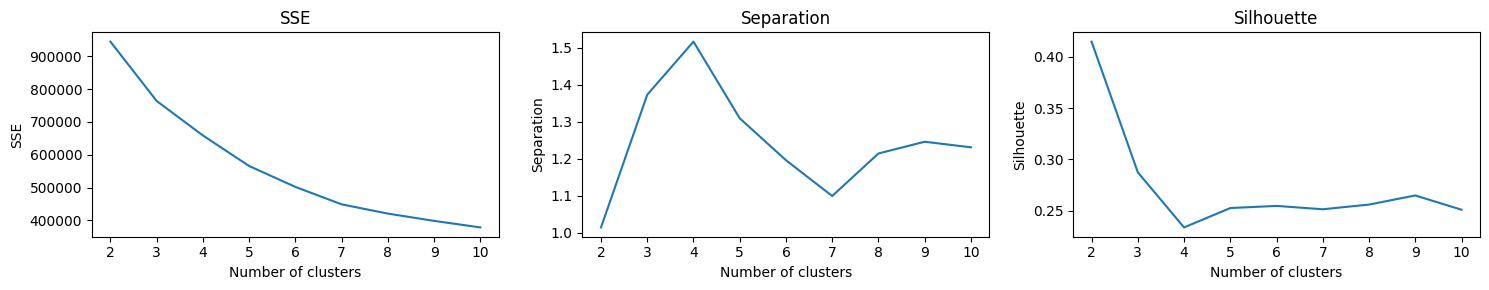

In [266]:
scoress_dict = scores(modelss=modelss, sampless=sampless, k_min=k_min, k_max=k_max, sample_size=5000, n_samples=3)
mean_scores = show_scores(scoress_dict=scoress_dict, k_min=k_min, k_max=k_max)

In [267]:
# Too much time to compute the silouette score on the entire dataset -> sampling

best_k = np.argmax(mean_scores)+k_min

scoress_dict = scores(modelss=modelss, sampless=sampless, k_min=best_k, k_max=best_k, sample_size=10000, n_samples=5)

print(f'\nBest mean silhouette score for k = {best_k}:')

for key in scoress_dict:
    print(f'{key} = {np.mean(scoress_dict[key][best_k])}')

k = 2


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:45<00:00,  9.15s/it]


Best mean silhouette score for k = 2:
SSE = 944734.0845960042
Separation = 1.0147015718388643
Silhouette = 0.41240124964697833


In [268]:
modelss, sampless = k_means(reduced_no_out_orig, k_min=best_k, k_max=best_k, max_iter=1000000)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


In [269]:
scoress_dict = scores(modelss=modelss, sampless=sampless, k_min=best_k, k_max=best_k, sample_size=10000, n_samples=5)

print(f'\nk = {best_k}:')

for key in scoress_dict:
    print(f'{key} = {np.mean(scoress_dict[key][best_k])}')

k = 2


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:40<00:00,  8.01s/it]


k = 2:
SSE = 944734.0845960032
Separation = 1.0147015718388641
Silhouette = 0.41320856773404246


/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


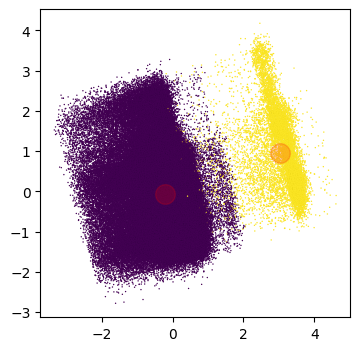

Cluster 0: 177714 points
Cluster 1: 13263 points


In [270]:
best_model = modelss[best_k][0]

best_model_samples = sampless[best_k][0]

points_pca, centroids_pca = perform_PCA(df=best_model_samples, centroids=best_model.cluster_centers_, n_components=2)

plt.figure(figsize=(4, 4))
plt.scatter(points_pca[:, 0], points_pca[:, 1], c=best_model.labels_, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', s=200, alpha=0.2)
plt.show()

cluster_labels, cluster_counts = np.unique(best_model.labels_, return_counts=True)
for l, c in zip(cluster_labels, cluster_counts):
    print(f'Cluster {l}: {c} points')

### K-means experiments on the augmented (i.e. with indicators) dataset (without outliers)

#### K-means on the full augmented dataset

In [195]:
k_min = 2
k_max = 10

modelss, sampless = k_means(df=df_no_out_s, k_min=k_min, k_max=k_max, max_iter=300)

100%|██████████| 9/9 [01:08<00:00,  7.60s/it]


k = 2


100%|██████████| 3/3 [00:06<00:00,  2.02s/it]


k = 3


100%|██████████| 3/3 [00:07<00:00,  2.36s/it]


k = 4


100%|██████████| 3/3 [00:07<00:00,  2.40s/it]


k = 5


100%|██████████| 3/3 [00:06<00:00,  2.16s/it]


k = 6


100%|██████████| 3/3 [00:06<00:00,  2.18s/it]


k = 7


100%|██████████| 3/3 [00:06<00:00,  2.19s/it]


k = 8


100%|██████████| 3/3 [00:06<00:00,  2.17s/it]


k = 9


100%|██████████| 3/3 [00:06<00:00,  2.03s/it]


k = 10


100%|██████████| 3/3 [00:06<00:00,  2.06s/it]


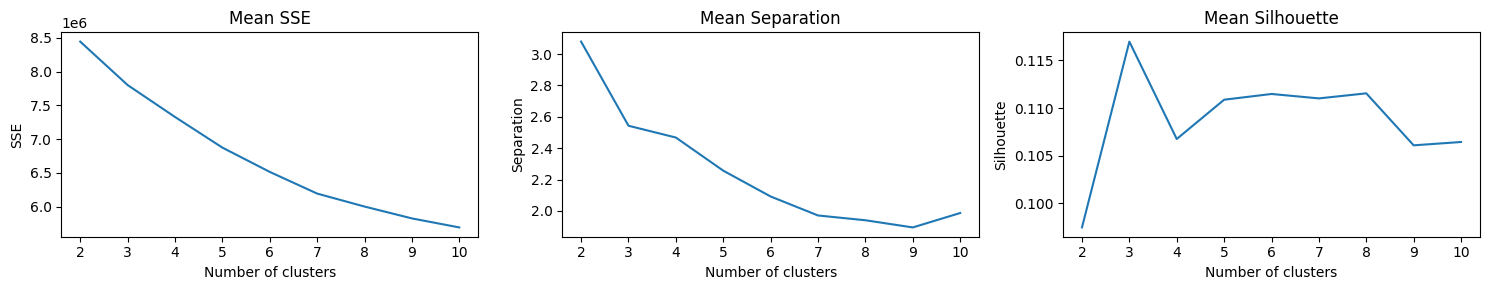

In [196]:
scoress_dict = scores(modelss=modelss, sampless=sampless, k_min=k_min, k_max=k_max, sample_size=5000, n_samples=3)
mean_scores = show_scores(scoress_dict=scoress_dict, k_min=k_min, k_max=k_max)

In [197]:
# Too much time to compute the silouette score on the entire dataset -> sampling

best_k = np.argmax(mean_scores)+k_min

scoress_dict = scores(modelss=modelss, sampless=sampless, k_min=best_k, k_max=best_k, sample_size=10000, n_samples=5)

print(f'\nBest mean silhouette score for k = {best_k}:')

for key in scoress_dict:
    print(f'{key} = {np.mean(scoress_dict[key][best_k])}')

k = 3


100%|██████████| 5/5 [00:46<00:00,  9.27s/it]


Best mean silhouette score for k = 3:
SSE = 7800452.233258557
Separation = 2.542879662925458
Silhouette = 0.11549977236927748


In [199]:
modelss, sampless = k_means(df_no_out_s, k_min=best_k, k_max=best_k, max_iter=1000000)

100%|██████████| 1/1 [00:04<00:00,  4.53s/it]


In [200]:
scoress_dict = scores(modelss=modelss, sampless=sampless, k_min=best_k, k_max=best_k, sample_size=10000, n_samples=5)

print(f'\nk = {best_k}:')

for key in scoress_dict:
    print(f'{key} = {np.mean(scoress_dict[key][best_k])}')

k = 3


100%|██████████| 5/5 [00:44<00:00,  8.92s/it]


k = 3:
SSE = 7800442.485924345
Separation = 2.547730292192497
Silhouette = 0.11440340386985974


/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


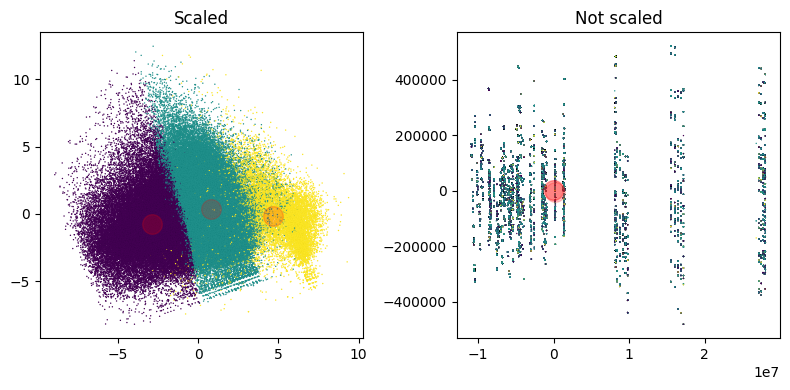

Cluster 0: 53861 points
Cluster 1: 124231 points
Cluster 2: 12885 points


In [202]:
best_model = modelss[best_k][0]
best_model_samples = sampless[best_k][0]

points_pca_s, centroids_pca_s = perform_PCA(df=best_model_samples, centroids=best_model.cluster_centers_, n_components=2)

orig_points = scaler_no_out.inverse_transform(best_model_samples)
orig_centroids = scaler_no_out.inverse_transform(best_model.cluster_centers_)

points_pca, centroids_pca = perform_PCA(df=orig_points, centroids=orig_centroids, n_components=2)

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.scatter(points_pca_s[:, 0], points_pca_s[:, 1], c=best_model.labels_, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca_s[:, 0], centroids_pca_s[:, 1], c='red', s=200, alpha=0.2)
plt.title('Scaled')

plt.subplot(1, 2, 2)
plt.scatter(points_pca[:, 0], points_pca[:, 1], c=best_model.labels_, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', s=200, alpha=0.2)
plt.title('Not scaled')

plt.tight_layout()
plt.show()

cluster_labels, cluster_counts = np.unique(best_model.labels_, return_counts=True)
for l, c in zip(cluster_labels, cluster_counts):
    print(f'Cluster {l}: {c} points')

#### Feature reduction

In [239]:
reduced_no_out_var = features_reduction_var(df_no_out_s, variance_threshold=1)
print('Survived columns (without outliers):----------------------------------------------')
print(f'n_cols = {len(reduced_no_out_var.columns)}')
print(reduced_no_out_var.columns)

Survived columns (without outliers):----------------------------------------------
n_cols = 48
Index(['latitude', 'longitude', 'min_age_participants', 'avg_age_participants',
       'max_age_participants', 'n_participants_teen', 'n_participants_adult',
       'n_males', 'n_females', 'n_killed', 'n_injured', 'n_arrested',
       'n_unharmed', 'n_participants', 'timestamp', 'povertyPercentage',
       'candidatevotes', 'totalvotes', 'state_population', 'p_males',
       'p_females', 'p_participants_teen', 'p_participants_adult', 'p_killed',
       'p_injured', 'p_arrested', 'p_unharmed',
       'month_cd_change_min_age_participants',
       'month_cd_change_avg_age_participants',
       'month_cd_change_max_age_participants', 'month_cd_ratio_males',
       'month_cd_ratio_females', 'month_cd_ratio_participants_teen',
       'month_cd_ratio_participants_adult', 'month_cd_ratio_killed',
       'month_cd_ratio_injured', 'month_cd_ratio_arrested',
       'month_cd_ratio_unharmed', 'month_cd_

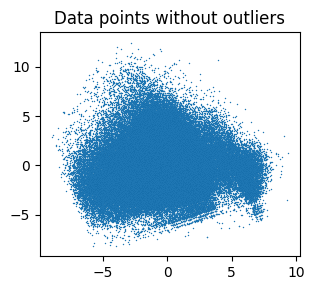

In [204]:
pca_no_out = perform_PCA(df=reduced_no_out_var, n_components=2)


plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.scatter(pca_no_out[:, 0], pca_no_out[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Data points without outliers')

plt.tight_layout()
plt.show()

In [249]:
reduced_no_out = features_reduction_corr(reduced_no_out_var, correlation_threshold=0.25)
print('Survived columns (without outliers):----------------------------------------------')
print(f'n_cols = {len(reduced_no_out.columns)}')
print(reduced_no_out.columns)

Survived columns (without outliers):----------------------------------------------
n_cols = 6
Index(['latitude', 'longitude', 'min_age_participants', 'n_participants_teen',
       'n_killed', 'timestamp'],
      dtype='object')


(the same as with the not augmented dataset)

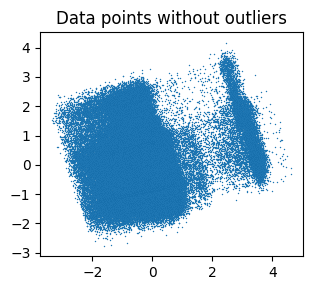

In [250]:
pca_no_out = perform_PCA(df=reduced_no_out, n_components=2)


plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.scatter(pca_no_out[:, 0], pca_no_out[:, 1], s=1, edgecolors='black', linewidths=0.001)
plt.title('Data points without outliers')

plt.tight_layout()
plt.show()

In [228]:
k_min = 2
k_max = 10

modelss, sampless = k_means(df=reduced_no_out, k_min=k_min, k_max=k_max, max_iter=300)

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:26<00:00,  2.92s/it]


k = 2


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:07<00:00,  2.55s/it]


k = 3


100%|██████████| 3/3 [00:08<00:00,  2.78s/it]


k = 4


100%|██████████| 3/3 [00:07<00:00,  2.50s/it]


k = 5


100%|██████████| 3/3 [00:09<00:00,  3.02s/it]


k = 6


100%|██████████| 3/3 [00:07<00:00,  2.36s/it]


k = 7


100%|██████████| 3/3 [00:07<00:00,  2.44s/it]


k = 8


100%|██████████| 3/3 [00:07<00:00,  2.45s/it]


k = 9


100%|██████████| 3/3 [00:07<00:00,  2.39s/it]


k = 10


100%|██████████| 3/3 [00:06<00:00,  2.24s/it]


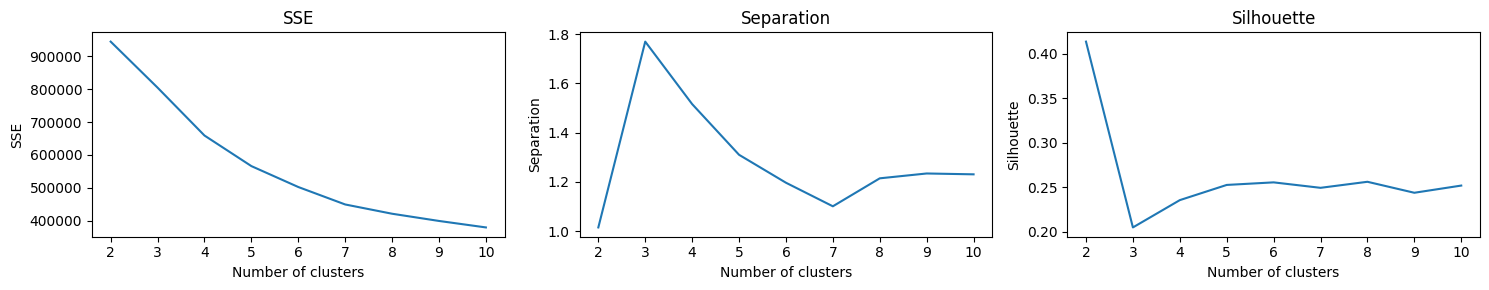

In [229]:
scoress_dict = scores(modelss=modelss, sampless=sampless, k_min=k_min, k_max=k_max, sample_size=5000, n_samples=3)
mean_scores = show_scores(scoress_dict=scoress_dict, k_min=k_min, k_max=k_max)

In [230]:
# Too much time to compute the silouette score on the entire dataset -> sampling

best_k = np.argmax(mean_scores)+k_min

scoress_dict = scores(modelss=modelss, sampless=sampless, k_min=best_k, k_max=best_k, sample_size=10000, n_samples=5)

print(f'\nBest mean silhouette score for k = {best_k}:')

for key in scoress_dict:
    print(f'{key} = {np.mean(scoress_dict[key][best_k])}')

k = 2


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:45<00:00,  9.20s/it]


Best mean silhouette score for k = 2:
SSE = 944734.0845960062
Separation = 1.0147015718388643
Silhouette = 0.41389858811447056


In [231]:
modelss, sampless = k_means(reduced_no_out, k_min=best_k, k_max=best_k, max_iter=1000000)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


In [232]:
scoress_dict = scores(modelss=modelss, sampless=sampless, k_min=best_k, k_max=best_k, sample_size=10000, n_samples=5)

print(f'\nk = {best_k}:')

for key in scoress_dict:
    print(f'{key} = {np.mean(scoress_dict[key][best_k])}')

k = 2


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:41<00:00,  8.36s/it]


k = 2:
SSE = 944734.0845960078
Separation = 1.0147015718388641
Silhouette = 0.4130000689443271


/home/claudia/code/DataMining/DataMining-2023/.env/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


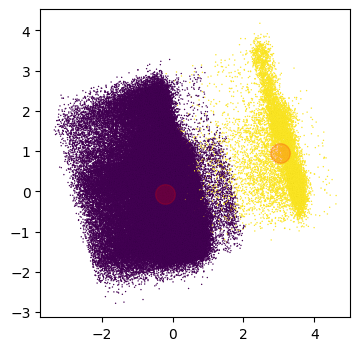

Cluster 0: 177714 points
Cluster 1: 13263 points


In [233]:
best_model = modelss[best_k][0]

best_model_samples = sampless[best_k][0]

points_pca, centroids_pca = perform_PCA(df=best_model_samples, centroids=best_model.cluster_centers_, n_components=2)

plt.figure(figsize=(4, 4))
plt.scatter(points_pca[:, 0], points_pca[:, 1], c=best_model.labels_, s=1, edgecolors='black', linewidths=0.001)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', s=200, alpha=0.2)
plt.show()

cluster_labels, cluster_counts = np.unique(best_model.labels_, return_counts=True)
for l, c in zip(cluster_labels, cluster_counts):
    print(f'Cluster {l}: {c} points')

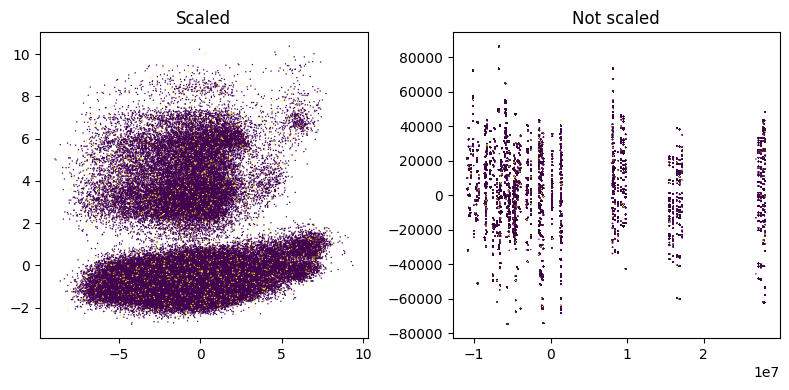

Cluster 0: 177714 points
Cluster 1: 13263 points


In [322]:
best_model = modelss[best_k][0]
best_model_samples = sampless[best_k][0]

points_pca_s = perform_PCA(df=df_no_out_s, n_components=5)

points_pca = perform_PCA(df=df_no_out, n_components=5)

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.scatter(points_pca_s[:, 0], points_pca_s[:, 3], c=best_model.labels_, s=1, edgecolors='black', linewidths=0.001)
plt.title('Scaled')

plt.subplot(1, 2, 2)
plt.scatter(points_pca[:, 0], points_pca[:, 3], c=best_model.labels_, s=1, edgecolors='black', linewidths=0.001)
plt.title('Not scaled')

plt.tight_layout()
plt.show()

cluster_labels, cluster_counts = np.unique(best_model.labels_, return_counts=True)
for l, c in zip(cluster_labels, cluster_counts):
    print(f'Cluster {l}: {c} points')

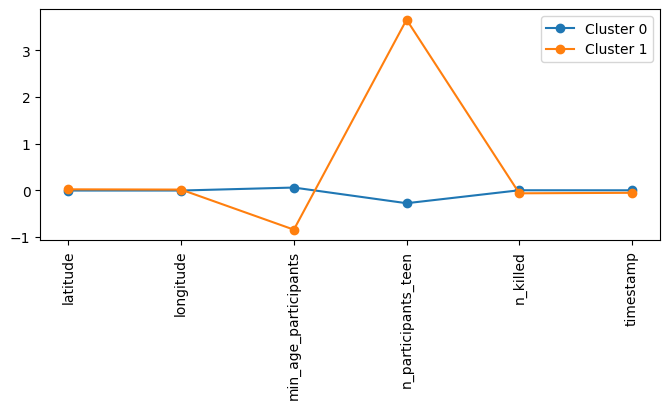

In [318]:
centers = best_model.cluster_centers_
cols = reduced_no_out.columns

plt.figure(figsize=(8, 3))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.xticks(range(len(cols)), cols, rotation='vertical')
plt.legend()
plt.show()

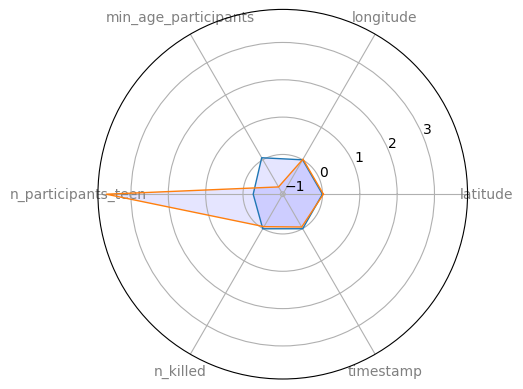

In [289]:
from math import pi

N = len(cols)
for i in range(0, len(centers)):
    angles = [n / float(N) * 2 * pi for n in range(N)]
    values = centers[i].tolist()
    values += values[:1]
    angles += angles[:1]

    ax = plt.subplot(polar=True)

    plt.xticks(angles[:-1], cols, color='grey', size=10) 

    ax.plot(angles, values, linewidth=1, linestyle='solid')

    ax.fill(angles, values, 'b', alpha=0.1)

In [323]:
cat_cols = ['date_month', 'date_day', 'date_year', 'congressional_district', 'state',
            'incident_characteristics1', 'city_or_county', 'party']

df_c_no_out =  df[df['OUTLIER'] == 0]
df_c_no_out = df_c_no_out[cat_cols]

In [346]:
party_xt_pct = pd.crosstab(best_model.labels_, df_c_no_out['party'])
party_xt_pct

party,DEMOCRAT,REPUBLICAN
row_0,,
0,101995,75719
1,7519,5744


In [459]:
a = party_xt_pct.values
cols = party_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

party_xt_pct_p = pd.DataFrame(d)
party_xt_pct_p

,DEMOCRAT,REPUBLICAN
0,0.573928,0.426072
1,0.566915,0.433085


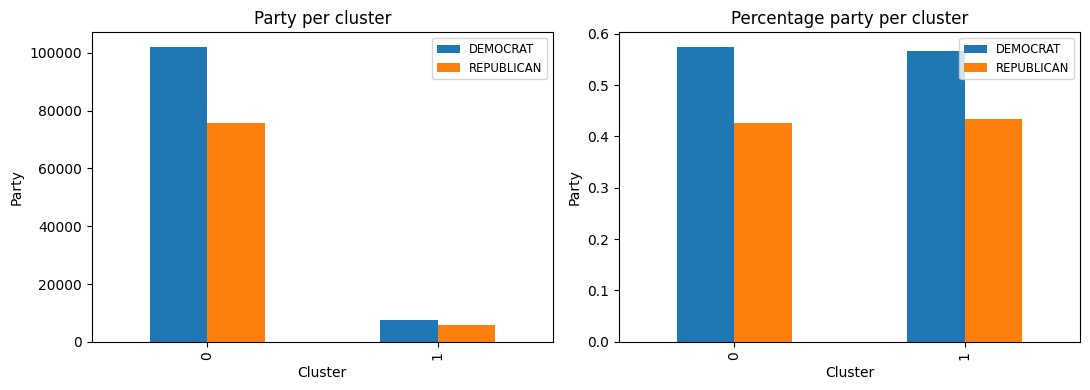

In [462]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4))

party_xt_pct.plot(kind='bar', stacked=False, title='Party per cluster', ax=axes[0])
axes[0].legend(fontsize='small', loc='upper right')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Party')

party_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage party per cluster', ax=axes[1])
axes[1].legend(fontsize='small', loc='upper right')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Party')

plt.tight_layout()
plt.show()

[[0.09694791 0.07957167 0.09592379 0.07640366 0.08191251 0.07636427
  0.08586268 0.08744387 0.0802863  0.08290849 0.075267   0.08110785]
 [0.09658448 0.08308829 0.0925884  0.07253261 0.07863983 0.07486994
  0.08987409 0.08587801 0.0859534  0.08173113 0.07517153 0.08308829]]
[ 1  2  3  4  5  6  7  8  9 10 11 12]
[ 1.81710956e-04 -1.75830970e-03  1.66769191e-03  1.93552515e-03
  1.63634302e-03  7.47165877e-04 -2.00570378e-03  7.82932002e-04
 -2.83355075e-03  5.88680851e-04  4.77361086e-05 -9.90221647e-04]
[-1.81710956e-04  1.75830970e-03 -1.66769191e-03 -1.93552515e-03
 -1.63634302e-03 -7.47165877e-04  2.00570378e-03 -7.82932002e-04
  2.83355075e-03 -5.88680851e-04 -4.77361086e-05  9.90221647e-04]


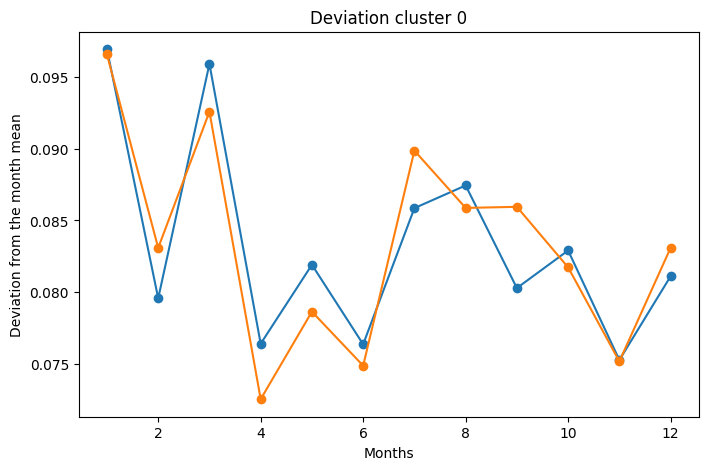

In [478]:
distrs = month_xt_pct_p.values
cols = month_xt_pct_p.columns
print(distrs)
avg_distr = np.mean(distrs, axis=0)
devs = []
for distr in distrs:
    devs.append(distr - avg_distr)

print(cols.values)
for dev in devs:
    print(dev)

# Plotting
fig, ax = plt.subplots(figsize=(8, 5))

# Bar plot with negative numbers
#bars = ax.bar(cols, devs[0], color='blue')
line, = ax.plot(cols, distrs[0], marker='o', linestyle='-')
line, = ax.plot(cols, distrs[1], marker='o', linestyle='-')

# Customize the plot
ax.set_xlabel('Months')
ax.set_ylabel('Deviation from the month mean')
ax.set_title(f'Deviation cluster {0}')

plt.show()


In [412]:
day_xt_pct = pd.crosstab(best_model.labels_, df_c_no_out['date_day'])
day_xt_pct

date_day,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
row_0,,,,,,,,,,,,,,,,,,,,,
0,6484,5596,5686,5793,5906,5781,5742,5760,5629,5619,...,5682,5793,5639,6052,5917,5925,5891,5517,5380,3545
1,476,434,447,423,445,448,429,429,438,393,...,399,443,417,423,436,462,432,426,426,271


In [413]:
a = day_xt_pct.values
cols = day_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

day_xt_pct_p = pd.DataFrame(d)
day_xt_pct_p

,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
0,0.036486,0.031489,0.031995,0.032597,0.033233,0.032530,0.032310,0.032412,0.031674,0.031618,...,0.031973,0.032597,0.031731,0.034055,0.033295,0.033340,0.033149,0.031044,0.030273,0.019948
1,0.035889,0.032723,0.033703,0.031893,0.033552,0.033778,0.032346,0.032346,0.033024,0.029631,...,0.030084,0.033401,0.031441,0.031893,0.032873,0.034834,0.032572,0.032119,0.032119,0.020433


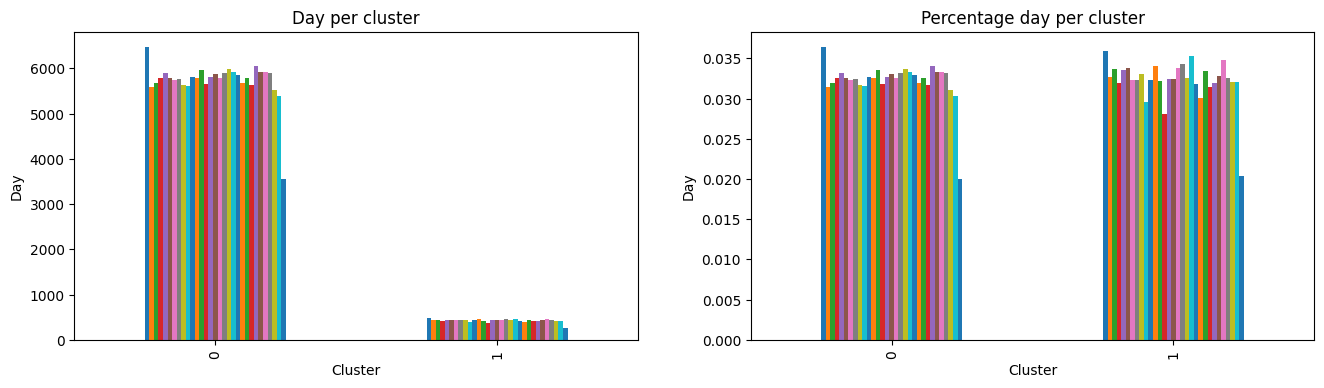

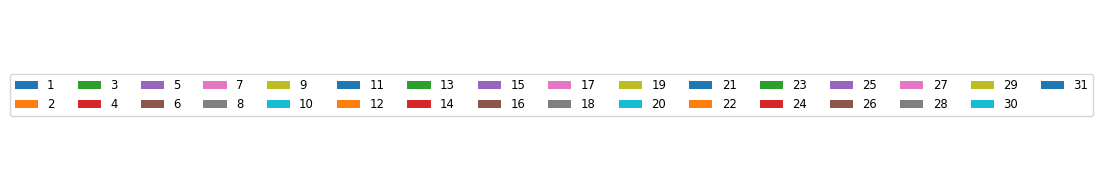

In [422]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

day_xt_pct.plot(kind='bar', stacked=False, title='Day per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Day')

day_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage day per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Day')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 2))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=16)
ax_legend.axis('off')

plt.tight_layout()
plt.show()

In [328]:
month_xt_pct = pd.crosstab(best_model.labels_, df_c_no_out['date_month'])
month_xt_pct

date_month,1,2,3,4,5,6,7,8,9,10,11,12
row_0,,,,,,,,,,,,
0,17229,14141,17047,13578,14557,13571,15259,15540,14268,14734,13376,14414
1,1281,1102,1228,962,1043,993,1192,1139,1140,1084,997,1102


In [390]:
a = month_xt_pct.values
cols = month_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

month_xt_pct_p = pd.DataFrame(d)
month_xt_pct_p

,1,2,3,4,5,6,7,8,9,10,11,12
0,0.096948,0.079572,0.095924,0.076404,0.081913,0.076364,0.085863,0.087444,0.080286,0.082908,0.075267,0.081108
1,0.096584,0.083088,0.092588,0.072533,0.078640,0.074870,0.089874,0.085878,0.085953,0.081731,0.075172,0.083088


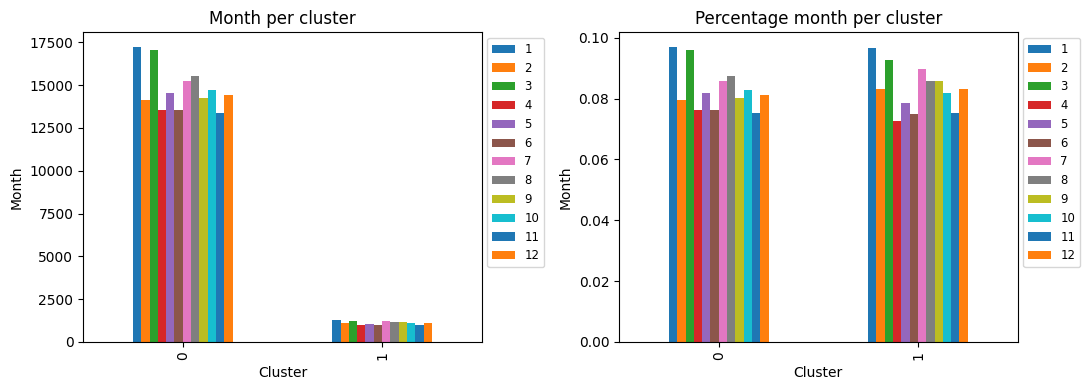

In [391]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4))

month_xt_pct.plot(kind='bar', stacked=False, title='Month per cluster', ax=axes[0])
axes[0].legend(fontsize='small', bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Month')

month_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage month per cluster', ax=axes[1])
axes[1].legend(fontsize='small', bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Month')

plt.tight_layout()
plt.show()

In [331]:
year_xt_pct = pd.crosstab(best_model.labels_, df_c_no_out['date_year'])
year_xt_pct

date_year,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0
row_0,,,,,,
0,36,29578,36672,48981,51156,11291
1,5,2214,2750,3710,3776,808


In [392]:
a = year_xt_pct.values
cols = year_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

year_xt_pct_p = pd.DataFrame(d)
year_xt_pct_p

,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0
0,0.000203,0.166436,0.206354,0.275617,0.287856,0.063535
1,0.000377,0.166931,0.207344,0.279726,0.284702,0.060921


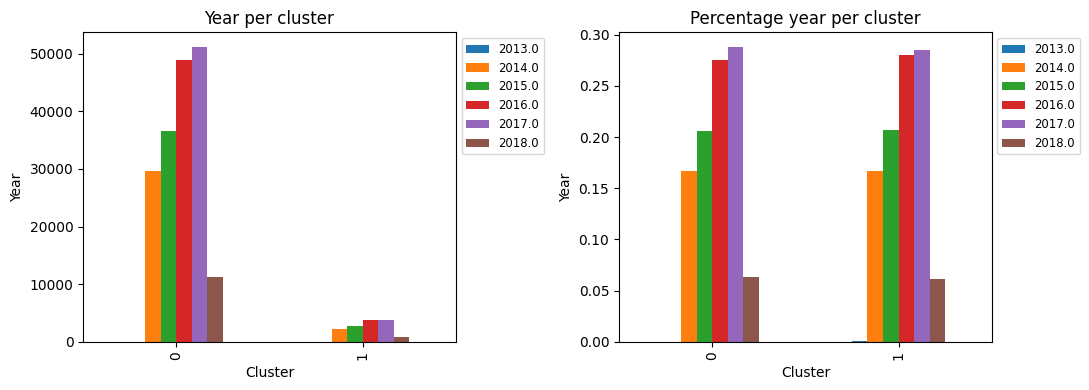

In [393]:
fig, axes = plt.subplots(1, 2, figsize=(11, 4))

year_xt_pct.plot(kind='bar', stacked=False, title='Year per cluster', ax=axes[0])
axes[0].legend(fontsize='small', bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Year')

year_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage year per cluster', ax=axes[1])
axes[1].legend(fontsize='small', bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Year')

plt.tight_layout()
plt.show()

In [334]:
state_xt_pct = pd.crosstab(best_model.labels_, df_c_no_out['state'])
state_xt_pct

state,ALABAMA,ALASKA,ARIZONA,ARKANSAS,CALIFORNIA,COLORADO,CONNECTICUT,DELAWARE,FLORIDA,GEORGIA,...,SOUTH DAKOTA,TENNESSEE,TEXAS,UTAH,VERMONT,VIRGINIA,WASHINGTON,WEST VIRGINIA,WISCONSIN,WYOMING
row_0,,,,,,,,,,,,,,,,,,,,,
0,4013,150,1787,2240,9560,2684,2582,1343,10466,6764,...,453,5726,8877,785,359,4516,2630,1243,3898,408
1,324,7,123,172,730,181,193,92,763,492,...,37,422,653,67,26,334,193,82,295,43


In [400]:
a = state_xt_pct.values
cols = state_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

state_xt_pct_p = pd.DataFrame(d)
state_xt_pct_p

,ALABAMA,ALASKA,ARIZONA,ARKANSAS,CALIFORNIA,COLORADO,CONNECTICUT,DELAWARE,FLORIDA,GEORGIA,...,SOUTH DAKOTA,TENNESSEE,TEXAS,UTAH,VERMONT,VIRGINIA,WASHINGTON,WEST VIRGINIA,WISCONSIN,WYOMING
0,0.022581,0.000844,0.010055,0.012605,0.053794,0.015103,0.014529,0.007557,0.058892,0.038061,...,0.002549,0.032220,0.049951,0.004417,0.00202,0.025412,0.014799,0.006994,0.021934,0.002296
1,0.024429,0.000528,0.009274,0.012968,0.055040,0.013647,0.014552,0.006937,0.057528,0.037096,...,0.002790,0.031818,0.049235,0.005052,0.00196,0.025183,0.014552,0.006183,0.022242,0.003242


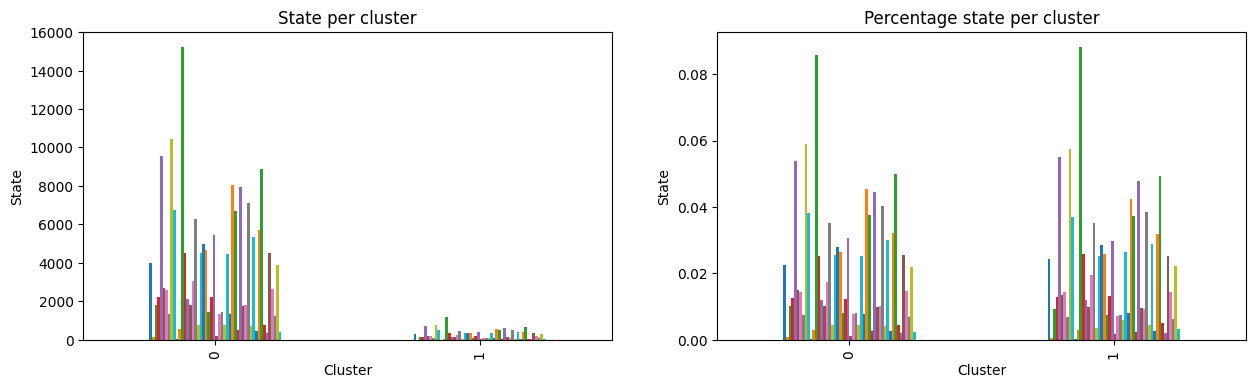

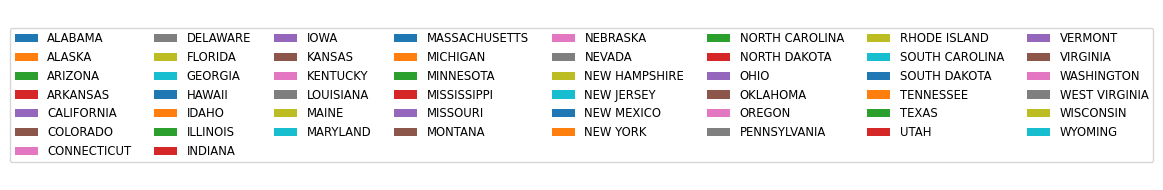

In [409]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

state_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

state_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 2))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

plt.tight_layout()
plt.show()

In [342]:
ic_xt_pct = pd.crosstab(best_model.labels_, df_c_no_out['incident_characteristics1'])
ic_xt_pct

incident_characteristics1,ARMED_ROBBERY,ATL-LE_CONFISCATION,ATTEMPTED_MURDER-SUICIDE,BAR-CLUB_INCIDENT,CAR_JACKING,CRIMINAL_ACT_WITH_STOLEN_GUN,DEFENSIVE_USE,DOMESTIC_VIOLENCE,DRIVE_BY,DRUG_INVOLVEMENT,...,SHOT_KILLED_ANIMAL,SHOT_SPOTTER,SPREE_SHOOTING,STOLEN_GUN,SUICIDE,SUICIDE_ATTEMPT,TSA_ACTION,UNDER_INFLUENCE,UNEXPECTED_GUN,UNLAWFUL_PURCHASE_SALE
row_0,,,,,,,,,,,,,,,,,,,,,
0,5455,317,4,19,242,26,35,175,56,785,...,223,4,3,608,29,63,1861,5,1054,1
1,416,22,0,2,16,2,1,17,6,60,...,16,0,0,52,1,8,137,0,81,0


In [410]:
a = ic_xt_pct.values
cols = ic_xt_pct.columns
ps = []
for i in range(len(cols)):
    ps.append([])

for row in a:
    dist = row / np.sum(row)
    for i in range(len(cols)):
        ps[i].append(dist[i])

d = {}
i = 0
for c in cols:
    d[c] = ps[i]
    i += 1

ic_xt_pct_p = pd.DataFrame(d)
ic_xt_pct_p

,ARMED_ROBBERY,ATL-LE_CONFISCATION,ATTEMPTED_MURDER-SUICIDE,BAR-CLUB_INCIDENT,CAR_JACKING,CRIMINAL_ACT_WITH_STOLEN_GUN,DEFENSIVE_USE,DOMESTIC_VIOLENCE,DRIVE_BY,DRUG_INVOLVEMENT,...,SHOT_KILLED_ANIMAL,SHOT_SPOTTER,SPREE_SHOOTING,STOLEN_GUN,SUICIDE,SUICIDE_ATTEMPT,TSA_ACTION,UNDER_INFLUENCE,UNEXPECTED_GUN,UNLAWFUL_PURCHASE_SALE
0,0.030695,0.001784,0.000023,0.000107,0.001362,0.000146,0.000197,0.000985,0.000315,0.004417,...,0.001255,0.000023,0.000017,0.003421,0.000163,0.000355,0.010472,0.000028,0.005931,0.000006
1,0.031365,0.001659,0.000000,0.000151,0.001206,0.000151,0.000075,0.001282,0.000452,0.004524,...,0.001206,0.000000,0.000000,0.003921,0.000075,0.000603,0.010329,0.000000,0.006107,0.000000


/tmp/ipykernel_24514/2204329852.py:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


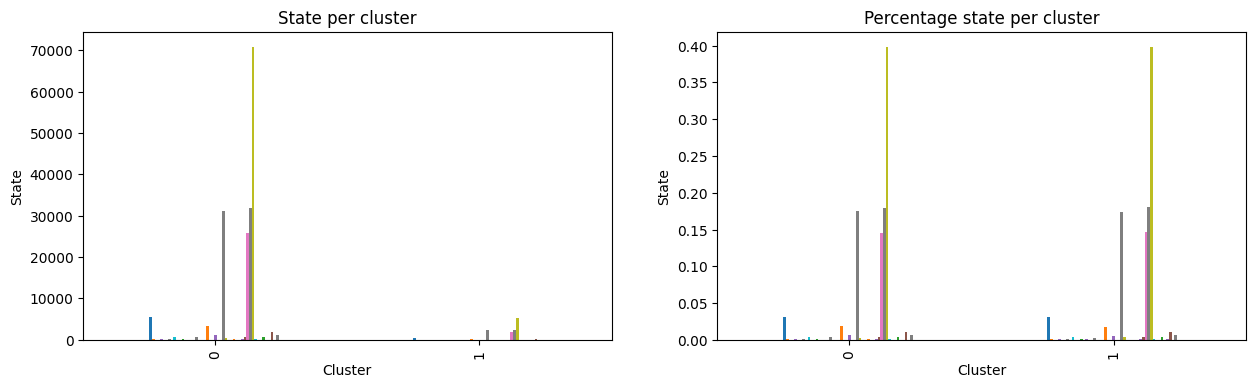

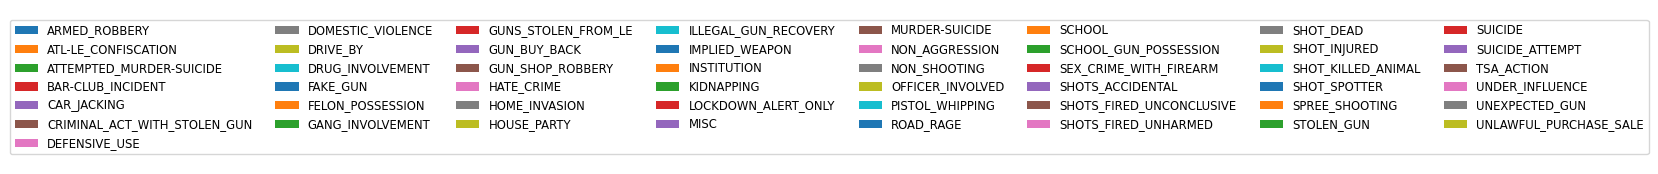

In [411]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

ic_xt_pct.plot(kind='bar', stacked=False, title='State per cluster', ax=axes[0])
axes[0].legend().set_visible(False)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('State')

ic_xt_pct_p.plot(kind='bar', stacked=False, title='Percentage state per cluster', ax=axes[1])
axes[1].legend().set_visible(False)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('State')

handles, labels = axes[0].get_legend_handles_labels()
figlegend = plt.figure(figsize=(8, 2))
ax_legend = figlegend.add_subplot(111)
ax_legend.legend(handles, labels, fontsize='small', loc='center', ncol=8)
ax_legend.axis('off')

plt.tight_layout()
plt.show()